# 1. Iniciar Spark y leer Bronze

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, regexp_replace, when, to_date, sum as spark_sum, count, lit

spark = SparkSession.builder \
    .appName("Medallion - Capas Silver y Gold") \
    .master("local[*]") \
    .getOrCreate()

# Ruta a Bronze (de Etapa 2)
bronze_path = "../../etapa2-bronze/data/bronze/sales_raw.parquet"
df_bronze = spark.read.parquet(bronze_path)

print("Filas en Bronze:", df_bronze.count())
df_bronze.printSchema()
df_bronze.show(5, truncate=False)

Filas en Bronze: 5500
root
 |-- sale_date: date (nullable = true)
 |-- store_id: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- product: string (nullable = true)
 |-- quantity: integer (nullable = true)
 |-- price: double (nullable = true)
 |-- total: double (nullable = true)
 |-- status: string (nullable = true)

+----------+--------+------------------------------------+----------+--------+-------+-------+---------+
|sale_date |store_id|customer_id                         |product   |quantity|price  |total  |status   |
+----------+--------+------------------------------------+----------+--------+-------+-------+---------+
|2025-07-27|NW-166  |8b1ff910-f298-4568-8f85-d7879a818f90|Smartphone|2       |1190.42|2380.84|Completed|
|2025-01-15|NW017   |03afe752-6931-46bf-a7f2-f1d57ddba376|Headphones|1       |1026.98|1026.98|Completed|
|2025-03-12|NW055   |7d3928fa-7308-4afb-9c1f-0759e812d758|Monitor   |1       |NULL   |575.75 |Returned |
|2025-03-14|NW-142  |9670544

# 2. Capa Silver – Limpieza y estandarización

## Limpieza de datos

1. Estandarizar store_id (eliminar prefijos/sufijos y normalizar)
2. Manejar nulos en columnas clave
3. Filtrar filas corruptas (ejemplo: total negativo o cantidad negativa)
4. Convertir fechas a formato estándar
5. Guardar Silver

## Verificación

1. Filas después de limpieza
2. store_id únicos
3. Ejemplos de datos

In [11]:
# 1. Estandarizar store_id (eliminar prefijos/sufijos y normalizar)
df_silver = df_bronze.withColumn(
    "store_id",
    regexp_replace(col("store_id"), r"[^0-9]", "")  # Quita todo lo que no sea número
).withColumn(
    "store_id",
    when(col("store_id") != "", col("store_id")).otherwise("UNKNOWN")
)

# 2. Manejar nulos en columnas clave
df_silver = df_silver.na.fill({
    "price": 0.0,
    "total": 0.0,
    "status": "Unknown",
    "quantity": 0
})

# 3. Filtrar filas corruptas (ejemplo: total negativo o cantidad negativa)
df_silver = df_silver.filter(
    (col("total") >= 0) & (col("quantity") >= 0)
)

# 4. Convertir fechas a formato estándar
df_silver = df_silver.withColumn("sale_date", to_date(col("sale_date")))

# 5. Guardar Silver
silver_path = "../data/silver/sales_clean.parquet"
df_silver.write.mode("overwrite").parquet(silver_path)
print("Capa Silver guardada en:", silver_path)

# Verificación
print("Filas después de limpieza:", df_silver.count())
df_silver.select("store_id").distinct().show(20, truncate=False)
df_silver.show(5, truncate=False)

Capa Silver guardada en: ../data/silver/sales_clean.parquet
Filas después de limpieza: 5500
+--------+
|store_id|
+--------+
|07      |
|125     |
|124     |
|51      |
|030     |
|169     |
|088     |
|15      |
|54      |
|155     |
|154     |
|132     |
|009     |
|101     |
|11      |
|138     |
|032     |
|065     |
|073     |
|29      |
+--------+
only showing top 20 rows
+----------+--------+------------------------------------+----------+--------+-------+-------+---------+
|sale_date |store_id|customer_id                         |product   |quantity|price  |total  |status   |
+----------+--------+------------------------------------+----------+--------+-------+-------+---------+
|2025-07-27|166     |8b1ff910-f298-4568-8f85-d7879a818f90|Smartphone|2       |1190.42|2380.84|Completed|
|2025-01-15|017     |03afe752-6931-46bf-a7f2-f1d57ddba376|Headphones|1       |1026.98|1026.98|Completed|
|2025-03-12|055     |7d3928fa-7308-4afb-9c1f-0759e812d758|Monitor   |1       |0.0    |575.75 |

# 3. Capa Gold – Tablas curadas y métricas de negocio

In [14]:
# 1. Tabla de hechos diaria: Revenue por día
df_gold_daily = df_silver.groupBy("sale_date") \
    .agg(
        spark_sum("total").alias("daily_revenue"),
        count("*").alias("num_transactions"),
        spark_sum("quantity").alias("total_quantity")
    ) \
    .orderBy("sale_date")

# 2. Tabla de hechos por producto y tienda (para análisis más granular)
df_gold_product_store = df_silver.groupBy("sale_date", "product", "store_id") \
    .agg(
        spark_sum("total").alias("revenue"),
        count("*").alias("transactions")
    )

# 3. Guardar en Gold
gold_daily_path = "../data/gold/sales_fact_daily.parquet"
gold_product_store_path = "../data/gold/sales_fact_product_store.parquet"

df_gold_daily.write.mode("overwrite").parquet(gold_daily_path)
df_gold_product_store.write.mode("overwrite").parquet(gold_product_store_path)

print("Tablas Gold generadas:")
print("- Daily:", gold_daily_path)
print("- Product-Store:", gold_product_store_path)

Tablas Gold generadas:
- Daily: ../data/gold/sales_fact_daily.parquet
- Product-Store: ../data/gold/sales_fact_product_store.parquet


# 4. Validación y visualización rápida

+----------+------------------+----------------+--------------+
|sale_date |daily_revenue     |num_transactions|total_quantity|
+----------+------------------+----------------+--------------+
|2024-12-21|24151.810000000005|10              |31            |
|2024-12-22|13844.140000000001|9               |24            |
|2024-12-23|27729.260000000002|15              |47            |
|2024-12-24|18798.09          |15              |37            |
|2024-12-25|30142.49          |12              |48            |
|2024-12-26|35226.26          |16              |53            |
|2024-12-27|22571.26          |11              |31            |
|2024-12-28|20570.24          |10              |30            |
|2024-12-29|21889.72          |10              |27            |
|2024-12-30|27064.719999999998|19              |54            |
+----------+------------------+----------------+--------------+
only showing top 10 rows


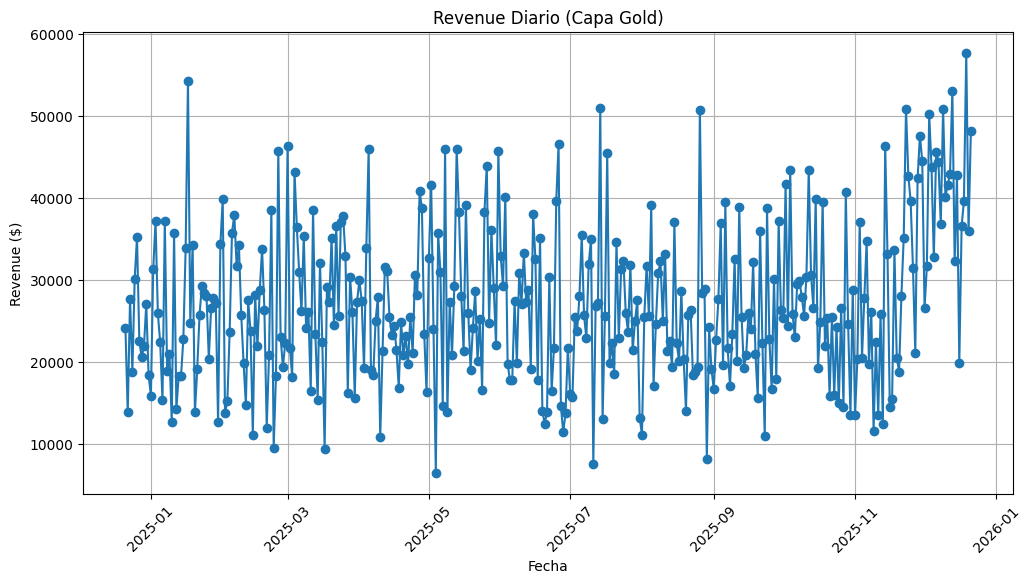

25/12/23 19:40:49 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 852153 ms exceeds timeout 120000 ms
25/12/23 19:40:49 WARN SparkContext: Killing executors is not supported by current scheduler.
25/12/23 19:40:53 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:53)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:342)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:132)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$

In [19]:
# Leer Gold para verificar
df_gold_daily = spark.read.parquet(gold_daily_path)
df_gold_daily.show(10, truncate=False)

# Convertir a Pandas para gráfica rápida
df_gold_pd = df_gold_daily.toPandas()

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(df_gold_pd["sale_date"], df_gold_pd["daily_revenue"], marker='o')
plt.title("Revenue Diario (Capa Gold)")
plt.xlabel("Fecha")
plt.ylabel("Revenue ($)")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()